Author: Aditya Anchan

Email: adijohnanc@gmail.com

Date: Nov 2022

In [17]:
%matplotlib inline
import numpy as np
from numpy import cos, sin, tan
import pandas as pd
import laspy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from sklearn.linear_model import RANSACRegressor


import matplotlib.patches as mpatches

# Edge detection

In [18]:
def local_ransac_plane(neighbourhood, threshold=1):
    """ 
    Fits a plane to a neighbourhood of points using RANSAC.

    Args:
        neighbourhood (np.array): Array of points of shape (n, 3)
        threshold (float): Distance threshold for inliers
    
    Returns:
        inlier_mask (np.array): Boolean array of shape (n,) indicating inliers
        plane_coef (np.array): Array of shape (3,) containing the plane coefficients
        intercept (float): Intercept of the plane

    """
    XY = neighbourhood[:,:2]
    Z = neighbourhood[:,2]

    ransac = RANSACRegressor(residual_threshold=threshold, max_trials=500, min_samples=None)
    ransac.fit(XY, Z)

    inlier_mask = ransac.inlier_mask_
    plane_coef = ransac.estimator_.coef_
    intercept = ransac.estimator_.intercept_

    return inlier_mask, plane_coef, intercept

In [19]:
def angular_gap(point, plane_normal, inliers, threshold=None):
    """ 
    Calculate the maximum angular gap for a point in a plane. If threshold specifies
    returns 1 if the maximum angular gap is greater than the threshold, 0 otherwise.

    Args:
        point (np.array): Point of shape (3,) to calculate the angular gap for
        plane_normal (np.array): Normal vector of the plane of shape (3,)
        inliers (np.array): Array of points of shape (n, 3) that are inliers to the plane
    
    Returns:
        result (float): Maximum angular gap for the point
    
    """
    plane_normal = plane_normal/np.linalg.norm(plane_normal)

    inlier_point_vectors = inliers - point
    inlier_point_vectors = (inlier_point_vectors.T / np.linalg.norm(inlier_point_vectors, axis=1)).T

    rand_vector = np.array([2, -5, 3])
    rand_vector = rand_vector/np.linalg.norm(rand_vector)
    
    u = np.cross(plane_normal, rand_vector) # Vector on plane orthogonal to plane normal
    u = u/np.linalg.norm(u)

    v = np.cross(plane_normal, u) # Vector on plane orthogonal to plane normal and u
    v = v/np.linalg.norm(v)

    d_u = np.dot(inlier_point_vectors, u) # Project inlier points onto u
    d_v = np.dot(inlier_point_vectors, v) # Project inlier points onto v

    theta_i = np.zeros(len(d_u)) # Calculate angle between inlier points and u


    for i in range(len(d_u)): # Angle for all four quadrants
        if d_u[i] >= 0 and d_v[i] >=0:
            theta_i[i] = np.arctan(d_u[i]/d_v[i])
        elif d_u[i] >= 0 and d_v[i] < 0:
            theta_i[i] = np.pi + np.arctan(d_u[i]/d_v[i])
        elif d_u[i] < 0 and d_v[i] < 0:
            theta_i[i] = np.pi + np.arctan(d_u[i]/d_v[i])
        else:
            theta_i[i] = 2*np.pi + np.arctan(d_u[i]/d_v[i])


    theta_i = np.sort(theta_i) - min(theta_i) # Sort angles and shift to start at 0
    delta_theta_i = np.ediff1d(theta_i) # Calculate difference between angles

    last_delta_theta = 2*np.pi - (theta_i[-1] - theta_i[0]) # Calculate difference between last and first angle
    max_delta_i = np.max(delta_theta_i) # Find maximum difference
    
    result = None

    if threshold == None: # Threshold for edge point
        result = max(max_delta_i, last_delta_theta)
    elif max(max_delta_i, last_delta_theta) >= threshold:
        result = 1
    else:
        result = 0
    
    return result


def edge_detection(point_data, k_neighbours=40, RANSAC_threshold=0.01, angular_gap_threshhold=None):
    """ 
    Detects edge points in a point cloud using the angular gap method.

    Args:
        point_data (np.array): Array of points of shape (n, 3)
        k_neighbours (int): Number of neighbours to use for the local RANSAC plane fitting
        RANSAC_threshold (float): Threshold for the RANSAC plane fitting
        angular_gap_threshhold (float): Threshold for the angular gap method (if None, returns the maximum angular gap)
    
    Returns:
        angular_gaps (np.array): Array of maximum angular gaps for each point or binary array of edge points
    """
    distance_tree = KDTree(point_data)
    angular_gaps = np.zeros(len(point_data))

    for idx, point in enumerate(point_data):
        # calculate k nearest neighbours
        local_points_idx = distance_tree.query(point, k=k_neighbours, p=2)[1]
        local_points = point_data[local_points_idx]

        # calculate ransac plane on points
        inlier_mask, plane_coef, intercept = local_ransac_plane(local_points, threshold=RANSAC_threshold)

        # if point is not in inliers, assign it a 0
        if inlier_mask[0] == False:
            angular_gaps[idx] = 0
            continue

        # else calculate angular gap of the point
        max_theta = angular_gap(point, np.array([-plane_coef[0], -plane_coef[1], 1]), np.delete(local_points[inlier_mask], 0, 0), threshold=angular_gap_threshhold)
        angular_gaps[idx] = max_theta 

    return angular_gaps


# Plotting Functions

In [20]:
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib

def scatter3d(x,y,z, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure()
    ax = Axes3D(fig)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    # ax.set_ylim([-4, 4])
    # ax.set_zlim([-4, 4])
    # ax.set_xlim([-4, 4])

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")



    ax.scatter(x, y, z, c=scalarMap.to_rgba(cs))
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap,label='Test')
    plt.show()


def scatter3d_p(x,y,z, title=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    
    if title != None:
        ax.set_title(title)

    if max(z) > 2.5:
        ax.set_xlim([-3, 3])
        ax.set_ylim([-3, 3])
        ax.set_zlim([-3, 3])
    else:
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])


    plt.show()


# Simulated Point Cloud Object Creation

In [31]:
def lineseg_dist(p, a, b):
    """ 
    Calculates the distance between a point and a line segment
    """
    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))


def generate_box(samples_per_side=100, error=0.05, height=1):
    """ 
    Generates a box point cloud with a given number of samples per side and a given error, and returns
    a mask of the ground truth edge points based on distance to the edges and the point cloud data. 

    Args:
        samples_per_side (int): Number of samples per side of the box
        error (float): Error of the point cloud (~ thickness of surfaces)
        height (float): Height of the box
    
    returns:
        surfacea_data (np.array): Array of points of shape (n, 3)
        edge_mask (np.array): Array of edge points of shape (n, 3)
    
    """
    # generate box
    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))
    surface_top = np.random.uniform(low=[-0.5, -0.5, height-error], high=[0.5, 0.5, height+error], size=(samples_per_side, 3))
    
    surface_side_1 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[-0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_2 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[0.5+error, -0.5+error, height+error], size=(samples_per_side, 3))

    surface_side_3 = np.random.uniform(low=[0.5-error, -0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_4 = np.random.uniform(low=[-0.5-error, 0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))


    surface_data = np.append(surface_base, surface_top, axis=0)
    surface_data = np.append(surface_data, surface_side_1, axis=0)
    surface_data = np.append(surface_data, surface_side_2, axis=0)
    surface_data = np.append(surface_data, surface_side_3, axis=0)
    surface_data = np.append(surface_data, surface_side_4, axis=0)

    # generate edge mask

    edge_mask = np.full(samples_per_side*6, False)

    for idx, point in enumerate(surface_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, 0.5, 0]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
    

    return surface_data, edge_mask




def generate_cylinder(samples=1000, error=0.02):
    """ 
    Generates a cylinder point cloud with a given number of samples and a given error. Returns the 
    point cloud data and a mask of the ground truth edge points based on distance to the edges.

    Args:
        samples (int): Number of samples of the cylinder
        error (float): Error of the point cloud (~ thickness of surfaces)

    Returns:
        points (np.array): Point cloud data of the cylinder
        edge_mask (np.array): Mask of the ground truth edge points
    
    """
    points = np.zeros((samples, 3))

    idx = 0
    for i in range(10000000):
        sample_point = np.random.uniform(low=[-1, -1, 0], high=[1.0, 1.0, 1], size=3)

        if ((0.5-error)**2 <= sample_point[0]**2 + sample_point[1]**2 <= 0.5**2) and (0 <= sample_point[2] <= 1):
            if idx >= samples:
                print(i)
                break
            else:
                points[idx] = sample_point
                idx += 1

    # edge mask
    edge_mask = np.full(len(points), False)
    for idx, point in enumerate(points):
        if ((0.5-error)**2 <= point[0]**2 + point[1]**2 <= 0.5**2) and (1-error <= point[2] <= 1+error or -error <= point[2] <= error):
        # if ((0.5-error)**2 <= point[0]**2 + point[1]**2 <= 0.5**2):
            edge_mask[idx] = True

                
    return points, edge_mask


def z_rotation_matrix(theta):
    R = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    return R


def generate_box_curved(samples_per_side=100, error=0.05, height=3):
    """ 
    Generates a curved box point cloud with a given number of samples and a given error. Returns the box and 
    a mask of the ground truth edge points based on distance to the edges.

    Args:
        samples_per_side (int): Number of samples of the box per side
        error (float): Error of the point cloud (~ thickness of surfaces)
        height (float): Height of the box
    
    Returns:
        points (np.array): Point cloud data of the box
        edge_mask (np.array): Mask of the ground truth edge points
    
    """

    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))
    surface_top = np.random.uniform(low=[-0.5, -0.5, height-error], high=[0.5, 0.5, height+error], size=(samples_per_side, 3))
    
    surface_side_1 = np.random.uniform(low=[-0.5-error, -0.5-error, 0-error], high=[-0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))
    surface_side_3 = np.random.uniform(low=[0.5-error, -0.5-error, 0-error], high=[0.5+error, 0.5+error, height+error], size=(samples_per_side, 3))


    surface_data = np.append(surface_base, surface_top, axis=0)
    surface_data = np.append(surface_data, surface_side_1, axis=0)
    surface_data = np.append(surface_data, surface_side_3, axis=0)

    # generate mask
    edge_mask = np.full(samples_per_side*4, False)

    for idx, point in enumerate(surface_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, 0.5, 0]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([0.5, -0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, height]), np.array([-0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, height]), np.array([0.5, 0.5, height])) <= error:
            edge_mask[idx] = True



    # transform prism
    points = np.zeros((4*samples_per_side, 3))

    for idx in range(4*samples_per_side):
        z_value = surface_data[idx][2].copy()
        angle_rot = np.pi/4 * z_value/height

        points[idx] = z_rotation_matrix(angle_rot) @ surface_data[idx]


    return points, edge_mask


def sample_triangle_points(pt1, pt2, pt3, samples=100):
    """ 
    Used for generating triangular point cloud surfaces. Used for pyrmaid object.add()
    """

    triangle_samples = np.zeros((samples, 3))

    for i in range(samples):
        a, b = np.random.random(), np.random.random()

        if a + b >= 1:
            a = 1-a
            b = 1-b

        x = pt1 + a*(pt2-pt1) + b*(pt3-pt1)
        triangle_samples[i] = x
        
    
    return triangle_samples




def generate_pyramid(samples_per_side=100, error=0):
    """ 
    Generates a pyramid point cloud. 
    
    Args:
        samples_per_side (int): Number of samples of the box per side
        error (float): Error of the point cloud (~ thickness of surfaces)
    
    Returns:
        points (np.array): Point cloud data of the pyramid
        edge_mask (np.array): Mask of the ground truth edge points
    
    """


    surface_base = np.random.uniform(low=[-0.5, -0.5, 0-error], high=[0.5, 0.5, 0+error], size=(samples_per_side, 3))

    pt1 = np.array([0, 0, 1])
    pt2 = np.array([0.5, -0.5, 0])
    pt3 = np.array([-0.5, -0.5, 0])
    pt4 = np.array([-0.5, 0.5, 0])
    pt5 = np.array([0.5, 0.5, 0])

    triangle1 = sample_triangle_points(pt1, pt2, pt3, samples=samples_per_side)
    triangle2 = sample_triangle_points(pt1, pt3, pt4, samples=samples_per_side)
    triangle3 = sample_triangle_points(pt1, pt4, pt5, samples=samples_per_side)
    triangle4 = sample_triangle_points(pt1, pt5, pt2, samples=samples_per_side)

    triangle_data = np.append(surface_base, triangle1, axis=0)
    triangle_data = np.append(triangle_data, triangle2, axis=0)
    triangle_data = np.append(triangle_data, triangle3, axis=0)
    triangle_data = np.append(triangle_data, triangle4, axis=0)

    edge_mask = np.full(len(triangle_data), False)
    for idx, point in enumerate(triangle_data):
        if lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, -0.5, 0]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([-0.5, 0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0.5, -0.5, 0]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([-0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([0.5, -0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([-0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True
        elif lineseg_dist(point, np.array([0, 0, 1]), np.array([0.5, 0.5, 0])) <= error:
            edge_mask[idx] = True

    return triangle_data, edge_mask


def variable_fold(samples_per_side=100, angle=90, error=0.05, class_error=0.05):
    """ 
    Generates a fold edge of specified angle. 

    Args:
        samples_per_side (int): Number of samples of the box per side
        angle (float): Angle of the fold
        error (float): Error of the point cloud (~ thickness of surfaces)
        class_error (float): Error of fold edge (~ thickness of edge)

    Returns:
        points (np.array): Point cloud data of the fold
        edge_mask (np.array): Mask of the ground truth edge points along the fold
    """

    surface_base = np.random.uniform(low=[-1.0, -0.5, 0-error], high=[0.0, 0.5, 0+error], size=(samples_per_side, 3))
    # surface_side_90 = np.random.uniform(low=[0.0-error, -0.5-error, 0-error], high=[0.0+error, 0.5+error, 1+error], size=(samples_per_side, 3))
    surface_side_angled = np.random.uniform(low=[0.0, -0.5, 0-error], high=[1.0, 0.5, 0+error], size=(samples_per_side, 3))

    angle_rad = np.pi/180 * (-angle)
    rotation_matrix = np.array([[cos(angle_rad), 0, sin(angle_rad)], 
                                [0, 1, 0], 
                                [-sin(angle_rad), 0,  cos(angle_rad)]])

    surface_side_angled = (rotation_matrix @ surface_side_angled.T).T

    surface_data = np.append(surface_base, surface_side_angled, axis=0)

    # generate edge mask

    edge_mask = np.full(samples_per_side*2, False)
    edge_idx = []


    for idx, point in enumerate(surface_data):
        if lineseg_dist(point, np.array([0.0, -0.5, 0]), np.array([0.0, 0.5, 0])) <= class_error:
            edge_mask[idx] = True
            edge_idx.append(idx)

    return surface_data, edge_mask, edge_idx

# Generate Data

In [22]:
box1, box_mask = generate_box(samples_per_side=500, error=0.05, height=3)

x_scale = 0.6
y_scale = 0.6
box_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

box1 = (box_transform @ box1.T).T

In [23]:
cylinder1, cylinder_mask = generate_cylinder(samples=4000, error=0.04)

x_scale = 0.6
y_scale = 0.6
cylinder_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

cylinder1 = (cylinder_transform @ cylinder1.T).T

132075


In [24]:
curved_box1, curved_mask = generate_box_curved(samples_per_side=1000, error=0.05, height=3)

x_scale = 0.6
y_scale = 0.6
curved_transform = np.array([[1, 0, x_scale], [0, 1, y_scale], [0, 0, 1]])

curved_box1 = (curved_transform @ curved_box1.T).T

In [25]:
pyramid1, pyramid_mask = generate_pyramid(samples_per_side=1000, error=0.05)

# Perform Edge Detection

### Rectangular Prism

<ipython-input-20-559950cc7daf>:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


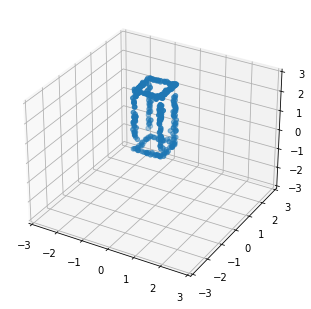

In [26]:
angles = edge_detection(box1, k_neighbours=200, RANSAC_threshold=0.05, angular_gap_threshhold=np.pi/2)

box1_final = (np.linalg.inv(box_transform) @ box1.T).T
edge_mask = angles.astype(dtype=bool)
_1 = edge_mask.copy()

scatter3d_p(box1_final[edge_mask][:,0], box1_final[edge_mask][:,1], box1_final[edge_mask][:,2])

### Cylinder

<ipython-input-20-559950cc7daf>:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


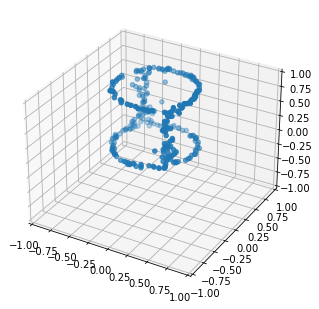

In [27]:
angles = edge_detection(cylinder1, k_neighbours=100, RANSAC_threshold=0.05, angular_gap_threshhold=np.pi/2)

cylinder1_final = (np.linalg.inv(cylinder_transform) @ cylinder1.T).T
edge_mask = angles.astype(dtype=bool)
_2 = edge_mask.copy()

scatter3d_p(cylinder1_final[edge_mask][:,0], cylinder1_final[edge_mask][:,1], cylinder1_final[edge_mask][:,2])

### Curved Box

<ipython-input-20-559950cc7daf>:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


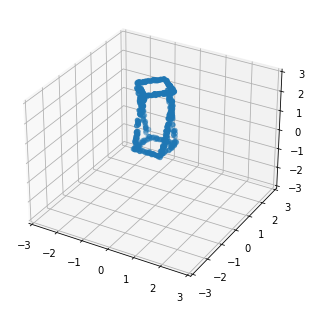

In [28]:
angles = edge_detection(curved_box1, k_neighbours=100, RANSAC_threshold=0.05, angular_gap_threshhold=np.pi/2)

curved_box1_final = (np.linalg.inv(curved_transform) @ curved_box1.T).T
edge_mask = angles.astype(dtype=bool)
_3 = edge_mask.copy()

scatter3d_p(curved_box1_final[edge_mask][:,0], curved_box1_final[edge_mask][:,1], curved_box1_final[edge_mask][:,2])

### Pyramid

<ipython-input-20-559950cc7daf>:34: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


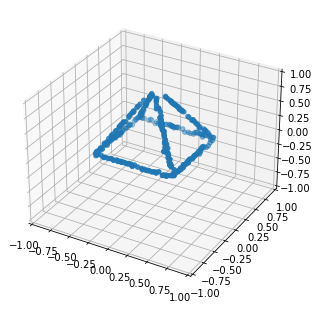

In [29]:
angles = edge_detection(pyramid1, k_neighbours=500, RANSAC_threshold=0.05, angular_gap_threshhold=np.pi/2)
edge_mask = angles.astype(dtype=bool)
_4 = edge_mask.copy()
scatter3d_p(pyramid1[edge_mask][:,0], pyramid1[edge_mask][:,1], pyramid1[edge_mask][:,2])